In [6]:
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer


In [7]:
  !pip install triton


In [8]:
import re
import numpy as np
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Load and process the Paul Graham essays text
with open('/content/holmes.txt', 'r') as file:
    text = file.read().lower()

# Remove special characters except for full stops

# Preprocess text
text = re.sub(r'http\S+', '', text)  # Remove URLs
text = re.sub(r'(\w)(\.)', r'\1 .', text)  # Separate periods attached to words or numbers
text = re.sub(r'[^a-zA-Z0-9 .]', ' ', text).lower()  # Keep only alphanumeric characters and periods
text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

# Tokenize the processed text
tokenizer = Tokenizer(filters='')  # Ensures no default filtering
tokenizer.fit_on_texts([text])

# Manually add period (.) if not present
if '.' not in tokenizer.word_index:
    tokenizer.word_index['.'] = len(tokenizer.word_index) + 1
stoi = tokenizer.word_index  # Word to index mapping
itos = {i: w for w, i in stoi.items()}  # Index to word mapping

# Tokenize text into words
words = text.split()

# Parameters
block_size = 5
X, Y = [], []

# Initialize context with full stops ('.')
context = [stoi.get('.', None)] * block_size

# Generate training pairs with the updated context
for i, word in enumerate(words):
    target = stoi.get(word, None)

    # Skip iteration if context or target has None
    if target is None or None in context:
        print(f"Skipping: Word '{word}' or context contains None.")
        continue

    X.append(list(context))  # Append a copy of the current context
    Y.append(target)

    # Print the first 20 context-target pairs for verification
    if i < 50:
        print(' '.join(itos[idx] for idx in context if idx is not None), '--->', itos.get(target, '?'))

    # Update context by shifting left and adding the current target
    context = context[1:] + [target]

# Convert to tensors for model input
import torch
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

. . . . . ---> project
. . . . project ---> gutenberg
. . . project gutenberg ---> s
. . project gutenberg s ---> the
. project gutenberg s the ---> adventures
project gutenberg s the adventures ---> of
gutenberg s the adventures of ---> sherlock
s the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> anyone
for the use of anyone ---> anywhere
the use of anyone anywhere ---> at
use of anyone anywhere at ---> no
of anyone anywhere at no ---> cost
anyone anywhere at no cost ---> and
anywhere at no cost and ---> with
at no cost and with ---> almost
no cost and with almost ---

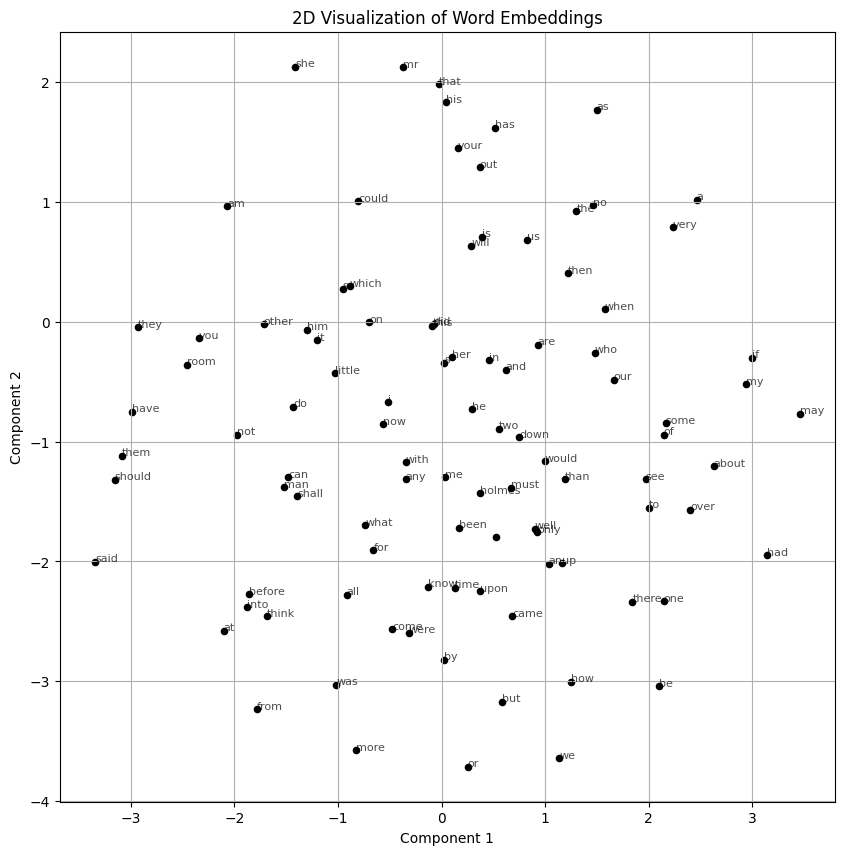

In [9]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define larger embedding size for words
embedding_dim = 64
hidden_size = 1024
# Assuming you have a tokenizer or a vocabulary list
vocab_size = len(tokenizer.word_index) + 1  # +1 if padding index is used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model and tensors to the device
embedding_layer = nn.Embedding(vocab_size, embedding_dim).to(device)

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x

# Function for training the model (pseudo-code, needs implementation)
def train_model(model, data_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:  # Assuming data_loader yields (input, target) pairs
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Function to plot word embeddings
def plot_word_embeddings(model, tokenizer, num_words_to_visualize=100, perplexity=30.0):
    # Extract the embedding layer weights
    embeddings = model.emb.weight.detach().cpu().numpy()

    # Choose the indices of words to visualize
    word_indices = np.arange(1, min(vocab_size, num_words_to_visualize))
    selected_embeddings = embeddings[word_indices]

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plot the embeddings
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color='k', s=20)  # Points color and size

    # Annotate the points with corresponding words
    for i, index in enumerate(word_indices):
        plt.annotate(tokenizer.index_word.get(index, '?'), (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

    plt.title("2D Visualization of Word Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# Example model usage
model = NextWord(block_size, vocab_size, embedding_dim).to(device)
#model = torch.compile(model)

# Pseudo-code for preparing your data loader and criterion
# data_loader = ...
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model (implement the data loading part)
# train_model(model, data_loader, criterion, optimizer, num_epochs=10)

# Visualize the word embeddings after training
plot_word_embeddings(model, tokenizer)


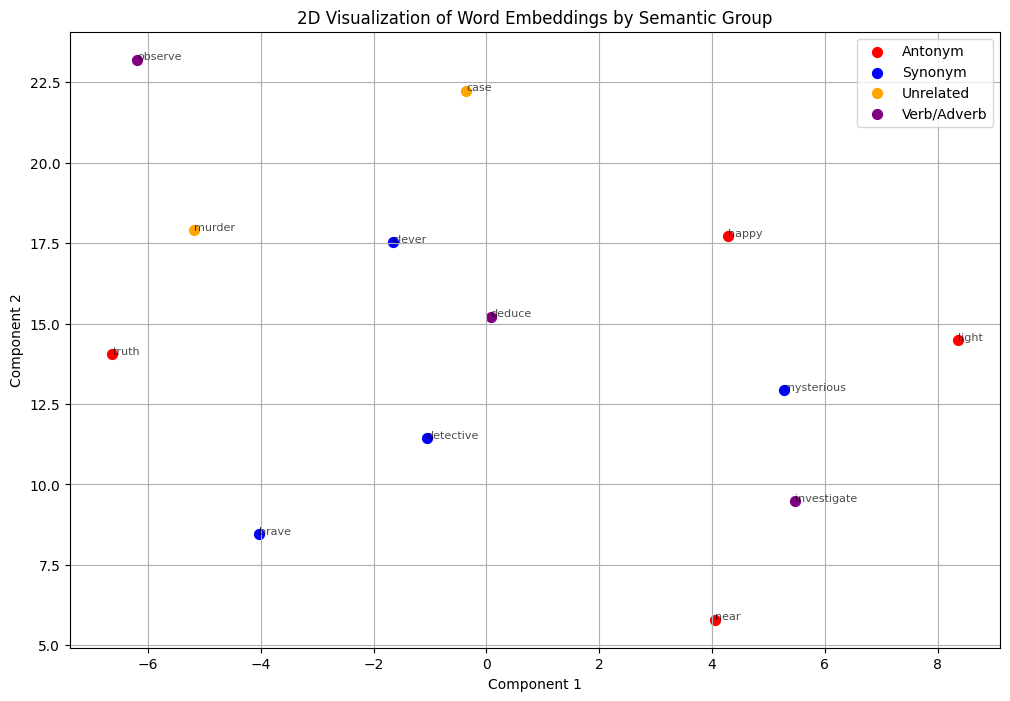

In [10]:

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Function to get indices for words in each category
def get_word_indices(word_list, tokenizer):
    return [tokenizer.word_index[word] for word in word_list if word in tokenizer.word_index]

# Define word groups (examples)
synonyms = ["clever", "detective", "mysterious", "brave"]
antonyms = ["happy", "truth", "light", "near"]
names_pronouns = ["Sherlock", "Watson", "I", "Mrs. Hudson"]
verbs_adverbs = ["investigate", "observe", "deduce", "conclude"]
unrelated = ["London", "Baker Street", "murder", "case"]
import matplotlib.pyplot as plt


# Retrieve indices for each group
synonym_indices = get_word_indices(synonyms, tokenizer)
antonym_indices = get_word_indices(antonyms, tokenizer)
names_pronouns_indices = get_word_indices(names_pronouns, tokenizer)
verbs_adverbs_indices = get_word_indices(verbs_adverbs, tokenizer)
unrelated_indices = get_word_indices(unrelated, tokenizer)

# Collect indices and labels
all_indices = synonym_indices + antonym_indices + names_pronouns_indices + verbs_adverbs_indices + unrelated_indices
all_labels = (["Synonym"] * len(synonym_indices) +
              ["Antonym"] * len(antonym_indices) +
              ["Name/Pronoun"] * len(names_pronouns_indices) +
              ["Verb/Adverb"] * len(verbs_adverbs_indices) +
              ["Unrelated"] * len(unrelated_indices))

# Extract embeddings for selected words
embeddings = model.emb.weight.detach().cpu().numpy()
selected_embeddings = embeddings[all_indices]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot embeddings with different colors for each category
plt.figure(figsize=(12, 8))
colors = {'Synonym': 'blue', 'Antonym': 'red', 'Name/Pronoun': 'green', 'Verb/Adverb': 'purple', 'Unrelated': 'orange'}

for label in np.unique(all_labels):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[label], s=50)

# Add labels for the words
for i, index in enumerate(all_indices):
    word = tokenizer.index_word.get(index, "?")
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title("2D Visualization of Word Embeddings by Semantic Group")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def generate_sentence(model, tokenizer, block_size, max_len=10):
    # Initialize context with zeros, representing the start token (you may replace it with the actual start token index if needed)
    context = [0] * block_size  # Adjust this if you have a specific start token
    sentence = ''

    for i in range(max_len):
        # Prepare the input tensor from the context
        x = torch.tensor(context).view(1, -1).to(device)  # Ensure input tensor is on the same device as the model

        # Forward pass to get predictions
        with torch.no_grad():  # Disable gradient calculation for inference
            y_pred = model(x)  # Get predictions from the model

        # Sample from the distribution
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()  # Sample from distribution

        # Convert index to word using the tokenizer
        word = tokenizer.index_word.get(ix, '?')  # Get word or default to '?'

        # Check for end token to stop generation
        if word == '<end>':  # Replace with your actual end token if needed
            break

        sentence += (word + ' ')  # Append the word to the sentence

        # Update context for the next word
        context = context[1:] + [ix]  # Update context with the new index

    return sentence.strip()  # Return the generated sentence


In [12]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: cream honoria flooring 8s lounged professor exclaimed dived horrify ascend
Generated Sentence 2: meant bullet amusement assumed winking income men abound whole lip
Generated Sentence 3: fair foolscap we investments upon sick continues tucked downward appearance
Generated Sentence 4: philadelphia extremity nosed 2001 galvanised flaw quotes severn filed proceed
Generated Sentence 5: moonlight rat much satisfactory bending plausible hailed practice entertaining bulldog
Generated Sentence 6: lumber elapsed series women resounded founded deposed groom retorted step
Generated Sentence 7: manufactory 2s tangled ideal unimpeachable loathing fix raise purveyor term
Generated Sentence 8: tackle beard axiom blame gladstone pull hours warren petty ground
Generated Sentence 9: sad grate quinsy sobered cumbrous implied rashness plan severn escaped
Generated Sentence 10: million monogram responsible friend through happily freed solve holiday joseph


In [13]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

emb.weight torch.Size([8184, 64])
lin1.weight torch.Size([1024, 320])
lin1.bias torch.Size([1024])
lin2.weight torch.Size([8184, 1024])
lin2.bias torch.Size([8184])


In [14]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Training loop
batch_size = 4096
print_every = 100
elapsed_time = []


for epoch in range(600):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        x = x.to(device)  # Ensure input tensor is on the same device as the model
        y = y.to(device)  # Ensure target tensor is also on the same device
        # Forward pass
        y_pred = model(x)

        # Compute loss
        loss = loss_fn(y_pred, y)

        # Backward pass and optimization
        loss.backward()
        opt.step()
        opt.zero_grad()

    end_time = time.time()
    elapsed_time.append(end_time - start_time)

    # Print progress at intervals
    if epoch % print_every == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Time: {elapsed_time[-1]:.2f} sec")

Epoch 0, Loss: 9.0351, Time: 1.97 sec
Epoch 100, Loss: 0.3798, Time: 1.67 sec
Epoch 200, Loss: 0.3294, Time: 1.66 sec
Epoch 300, Loss: 0.5833, Time: 1.65 sec
Epoch 400, Loss: 0.1843, Time: 1.67 sec
Epoch 500, Loss: 0.5140, Time: 1.66 sec


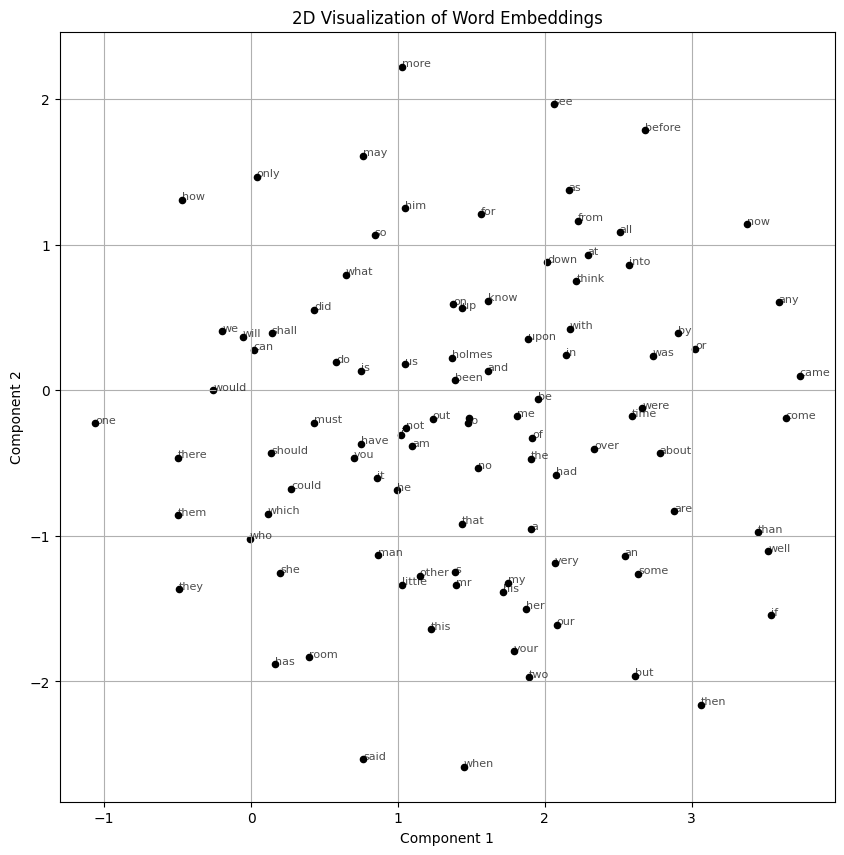

In [15]:
# Visualize the embedding

plot_word_embeddings(model, tokenizer)

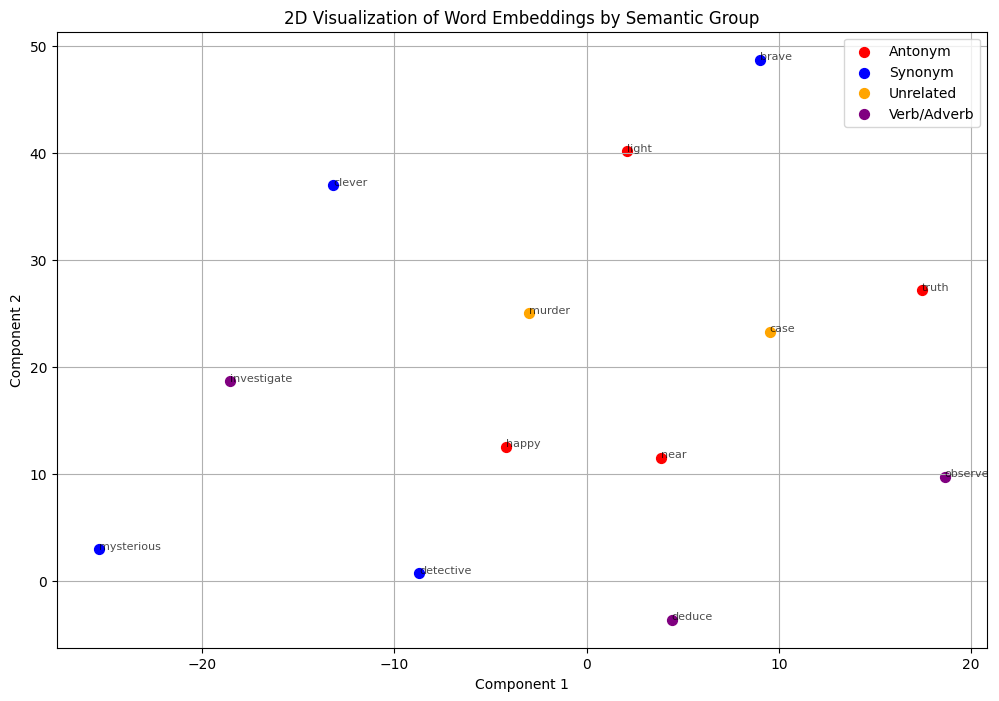

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Function to get indices for words in each category
def get_word_indices(word_list, tokenizer):
    return [tokenizer.word_index[word] for word in word_list if word in tokenizer.word_index]

# Define word groups (examples)
synonyms = ["clever", "detective", "mysterious", "brave"]
antonyms = ["happy", "truth", "light", "near"]
names_pronouns = ["Sherlock", "Watson", "I", "Mrs. Hudson"]
verbs_adverbs = ["investigate", "observe", "deduce", "conclude"]
unrelated = ["London", "Baker Street", "murder", "case"]
import matplotlib.pyplot as plt


# Retrieve indices for each group
synonym_indices = get_word_indices(synonyms, tokenizer)
antonym_indices = get_word_indices(antonyms, tokenizer)
names_pronouns_indices = get_word_indices(names_pronouns, tokenizer)
verbs_adverbs_indices = get_word_indices(verbs_adverbs, tokenizer)
unrelated_indices = get_word_indices(unrelated, tokenizer)

# Collect indices and labels
all_indices = synonym_indices + antonym_indices + names_pronouns_indices + verbs_adverbs_indices + unrelated_indices
all_labels = (["Synonym"] * len(synonym_indices) +
              ["Antonym"] * len(antonym_indices) +
              ["Name/Pronoun"] * len(names_pronouns_indices) +
              ["Verb/Adverb"] * len(verbs_adverbs_indices) +
              ["Unrelated"] * len(unrelated_indices))

# Extract embeddings for selected words
embeddings = model.emb.weight.detach().cpu().numpy()
selected_embeddings = embeddings[all_indices]

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Plot embeddings with different colors for each category
plt.figure(figsize=(12, 8))
colors = {'Synonym': 'blue', 'Antonym': 'red', 'Name/Pronoun': 'green', 'Verb/Adverb': 'purple', 'Unrelated': 'orange'}

for label in np.unique(all_labels):
    indices = [i for i, l in enumerate(all_labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label, color=colors[label], s=50)

# Add labels for the words
for i, index in enumerate(all_indices):
    word = tokenizer.index_word.get(index, "?")
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)

plt.title("2D Visualization of Word Embeddings by Semantic Group")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Example of generating multiple sentences
for i in range(10):
    generated_sentence = generate_sentence(model, tokenizer, block_size, max_len=10)
    print(f"Generated Sentence {i + 1}: {generated_sentence}")


Generated Sentence 1: you are coming for a cab in a replacement to
Generated Sentence 2: it was a good night . i kissed her and
Generated Sentence 3: i tm the police but i came where the room
Generated Sentence 4: is tm the only one of the highest in england
Generated Sentence 5: tm the king of the doctor the hatherley upon his
Generated Sentence 6: is more than a young man one day . you
Generated Sentence 7: you are coming . as i is always see such
Generated Sentence 8: you must have been your advice with the said where
Generated Sentence 9: tm the project gutenberg tm the bedroom window is a
Generated Sentence 10: you are not very vulnerable from above holmes remarked as


In [19]:
import os

# Define directory to save models
model_dir = "/content/saved_models"
os.makedirs(model_dir, exist_ok=True)

# Save model with unique configurations
def save_model_variant(model, variant_name):
    torch.save(model.state_dict(), os.path.join(model_dir, f"{variant_name}.pt"))

# Example of saving model variants
save_model_variant(model, "embedding64_hidden1024_holmes")

In [20]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00


In [21]:
# Define the NextWord model and save it to model.py

code = """
# model.py
# model.py
import torch
import torch.nn as nn

class NextWord(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size=1024):
        super(NextWord, self).__init__()
        self.block_size = block_size
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)  # Flatten the embedding output
        x = torch.sin(self.lin1(x))  # Apply activation
        x = self.lin2(x)  # Output logits for vocabulary size
        return x



"""

# Save code to model.py
with open("/content/model.py", "w") as file:
    file.write(code)

print("model.py created successfully!")

model.py created successfully!


In [22]:
# Define functions to save and load tokenizer, then save it to tokenizer.py

code = """
import pickle

def save_tokenizer(tokenizer, path='/content/tokenizer_64_holmes.pkl'):
    # Save the tokenizer to a file
    with open(path, 'wb') as f:
        pickle.dump(tokenizer, f)

def load_tokenizer(path='/content/tokenizer_64_holmes.pkl'):
    # Load the tokenizer from a file
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer
"""

# Save code to tokenizer.py
with open("/content/tokenizer_64_holmes.py", "w") as file:
    file.write(code)

print("tokenizer_64_holmes.py created successfully!")

tokenizer_64_holmes.py created successfully!


In [23]:
from tokenizer_64_holmes import save_tokenizer
save_tokenizer(tokenizer)